In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from sklearn import metrics
from tqdm import tqdm
import numpy as np
import pandas as pd
from torch.optim import Adam
import matplotlib.pyplot as plt

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## Data

In [5]:
class SpikeDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = nn.functional.one_hot(y_data.to(torch.int64), num_classes=2)
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.y_data)

In [6]:
train_data = pd.read_csv("train.csv", header=None)

train_data = train_data.fillna(0)

#train_data = train_data.sample(frac=1, random_state=1)

x = train_data.iloc[:, :48].values.tolist()
y = np.squeeze(train_data.iloc[:, 48:].astype(int).values.tolist())

train = SpikeDataset(torch.FloatTensor(x),
                     torch.Tensor(y)
)

## Model

In [7]:
class SpikeNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=2):
        super(SpikeNet, self).__init__()
        self.hidden = 32
        self.net = nn.Sequential(
            nn.Conv1d(1, 48, 5, padding=2),
            nn.Conv1d(48, self.hidden, 16, stride=16),
            nn.LeakyReLU(0.1),
            nn.Conv1d(self.hidden, self.hidden, 7, padding=3),
        )
        
        for i in range(6):
            self.net.add_module('conv{}'.format(i), self.__block(self.hidden, self.hidden))

        self.net.add_module('final', nn.Sequential(
            nn.Conv1d(self.hidden, out_channels, 3),
            nn.Sigmoid()
        ))
        
    def __block(self, inchannels, outchannels):
        return nn.Sequential(
            nn.Dropout(p=0.1, inplace=True),
            nn.Conv1d(inchannels, outchannels, 5, padding=2),
            nn.LeakyReLU(0.1),
            nn.Conv1d(outchannels, outchannels, 5, padding=2),
            nn.LeakyReLU(0.1),
        )
    
    def forward(self, x):
        return self.net(x)

## Train

In [8]:
train_loader = DataLoader(dataset=train, batch_size=1, shuffle=True)

test_data = pd.read_csv("test.csv", header=None)

print(test_data.shape)

x_test = test_data.iloc[:, :48].values.tolist()
y_test = np.squeeze(test_data.iloc[:, 48:].astype(int).values.tolist())

test = SpikeDataset(
    torch.FloatTensor(x_test),
    torch.Tensor(y_test)
)

test_loader = DataLoader(dataset=test, batch_size=1)

(9762, 49)


In [9]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    tensor = list(Y[0].to(torch.float32))
    print(Y)
    value = tensor.index(max(tensor))
    print(value)
    break

torch.Size([1, 48]) torch.Size([1, 2])
tensor([[0, 1]])
1


In [19]:
Y_shuffled_all = []
Y_preds_all = []
Y_preds_sc_all = []

In [20]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)

            loss = loss_fn(preds.squeeze(dim=-1), Y[0].to(torch.float32))
            losses.append(loss.item())
            
            tensor_pred = list(preds.squeeze(dim=-1))
            tensor_y = list(Y[0].to(torch.float32))

            Y_shuffled.append(tensor_y.index(max(tensor_y)))
            Y_preds.append(tensor_pred.index(max(tensor_pred)))
            Y_preds_sc_all.append(max(tensor_pred))
        Y_shuffled_all.append(Y_shuffled)
        Y_preds_all.append(Y_preds)
        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled, Y_preds)))

In [21]:
loss_his = []

In [22]:
def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        losses_last = []
        iter = 0
        for X, Y in tqdm(train_loader):
            Y_preds = model(X)

            loss = loss_fn(Y_preds.squeeze(dim=-1), Y[0].to(torch.float32))
            losses.append(loss.item())
            losses_last.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            iter +=1
            if iter % 50 == 0:
                loss_his.append(torch.tensor(losses_last).mean())
                losses_last.clear()


        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        CalcValLossAndAccuracy(model, loss_fn, val_loader)
        torch.save(model.state_dict(), f"out/modelv2-ep-{i}.pt")

In [ ]:
epochs = 1
learning_rate = 1e-3

loss_fn = nn.BCELoss()
conv_classifier = SpikeNet()
optimizer = Adam(conv_classifier.parameters(), lr=learning_rate)

Y_shuffled_all = []
Y_preds_all = []
Y_preds_sc_all = []

TrainModel(conv_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

In [38]:
index = 0

In [39]:
accuracy_score(Y_shuffled_all[index], Y_preds_all[index])

0.9735709895513215

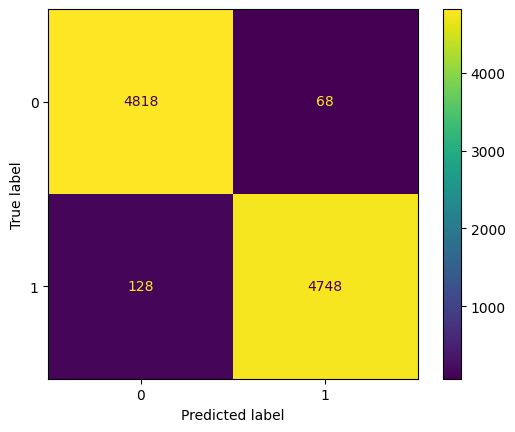

In [17]:
cm = metrics.confusion_matrix(Y_shuffled_all[index],Y_preds_all[index])

pcm = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
pcm.plot()
plt.show()